### Funciones para Figuras

In [27]:
%matplotlib inline  
import numpy as np 
import pandas as pd 
import pylab as pl 
import datetime as dt 
import os 
from wmf import wmf 
from multiprocessing import Pool
import matplotlib
import MySQLdb
import json
# from cpr import cpr
import pickle
import alarmas as al
#Ignorar avisos pendejos
import warnings
warnings.filterwarnings('ignore')
import funciones_sora as fs
import glob

Cosas que deben ir en el cron

In [28]:
#Lectura de ruta de configuracion.
ruta_config= '/media/nicolas/Home/Jupyter/Soraya/git/Alarmas/04_web_hidrologia/hidrologia/configfile_web.md'
listconfig = al.get_rutesList(ruta_config)

#Lectura de rutas
ruta_consultaN3h=al.get_ruta(listconfig,'ruta_consultaN3h')
ruta_estadistico=al.get_ruta(listconfig,'ruta_estadistico')
ruta_pluvioforecast=al.get_ruta(listconfig,'ruta_pluvioforecast')
rutaN=al.get_ruta(listconfig,'rutaN_infoeventos')
rutaP=al.get_ruta(listconfig,'rutaP_infoeventos')
rutafigsN=al.get_ruta(listconfig,'rutaFigsNbandas')
rutafigsP=al.get_ruta(listconfig,'rutaFigsPbandas')
#Lectura del assignfile
dfconfig=pd.read_json(al.get_ruta(listconfig,'ruta_JSONinfosirenas'))

In [29]:
timedeltaEv=5#min
# label time
hours=np.arange(-3,4)
rng1=[]
for i in range(hours.size):
    if hours[i]<0:
        rng1.append('-0'+str(np.abs(hours[i]))+':00')
    else:
        rng1.append('0'+str(np.abs(hours[i]))+':00')
rng1=np.array(rng1)

In [30]:
#Estadistico
# se lee la info del pronostico Estadistico 30m
f=open(ruta_estadistico)
n_pronos1=pickle.load(f)
f.close()
n_pronos=pd.DataFrame(n_pronos1)
columns=['codigo','n30p25','n30p50','n30p75','Ttop25','Ttop50','Ttop75']
n_pronos.columns=columns
n_pronos['codigo']=map(int,n_pronos['codigo'])
n_pronos.index=n_pronos['codigo']
n_pronos=n_pronos.drop('codigo',axis=1)
n_pronos=n_pronos.T

#Pluvio Forecast
f = open(ruta_pluvioforecast+'_cast_normal.rain','r')
cast_normal = pickle.load(f)
f.close()

import cprv1.cprv1 as cpr1

#fechas de consulta nivel.
start=(dt.datetime.now()-pd.Timedelta('3 hours')).strftime('%Y-%m-%d-%H:%M')
end=dt.datetime.now().strftime('%Y-%m-%d-%H:%M')

self= cpr.Nivel(codigo=est,user='sample_user',passwd='s@mple_p@ss')
level=self.level(start,end)

funcion

In [6]:
def plotN_vs_History(est,ruta_consultaN3h,dfconfig,n_pronos,rutaN,rutafigsN,rng1,timedeltaEv,start=None,end=None):

    # Si no se especifica las fechas, se  consulta por defecto la consulta ya realizadapor otro con.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               i no se especifican las fechas, se consulta por defecto la consulta ya realizada por otro cron.
    if start is None and end is None:
        consulta_N3h=pd.read_csv(ruta_consultaN3h)
        level=pd.Series(consulta_N3h[str(est)].values,index=pd.to_datetime(consulta_N3h[consulta_N3h.keys()[0]]))
    #si si, se ejecuta una consulta
    else:
        #consulta
        self= cpr.Nivel(est)
        level=self.get_level(start,end)
        level=level['nivel']

    #Si la media de los ultimos 5 minutos, o el dato de los 5min es nan- no hay datos- : No hago nada.
    if np.isnan(level[-5:].mean()) or np.isnan(level[-2]):
        print 'No hay datos en los ultimos 5 min.'
        pass
    else:
        #resample
        level=(level.resample('5T').mean())
        # Se abren los archivos historicos.
        #Eventos.
        Nmax=pd.read_csv(rutaN+'Nmax_'+str(est)+'.csv')
        df=Nmax
        df.index=pd.to_datetime(df[df.keys()[0]])
        df.index.name=''
        Nmax=df.drop(df.keys()[0],axis=1)

        #BandasN
        Nbandas=pd.read_csv(rutaN+'bandas_'+str(est)+'.csv')

        #Figura Nshape
        if int(est) in n_pronos.columns:
            if n_pronos[int(est)].all() == 0:
                na=0;nb=0;nc=0
                ta=0;tb=0;tc=0
                #cosas para plotear - se plotea normal.
                serie_obs=level.values
                serie_xEst=level.size+((60/timedeltaEv)/2)
            #si no
            else:
                na=n_pronos[int(est)]['n30p25'];nb=n_pronos[int(est)]['n30p50'];nc=n_pronos[int(est)]['n30p75']
                ta=n_pronos[int(est)]['Ttop25'];tb=n_pronos[int(est)]['Ttop50'];tc=n_pronos[int(est)]['Ttop75']
                #cosas para plotear
                #si N30m es mayor que observado
                if nb > level[-2]:
                    serie_obs=level.values[(60/timedeltaEv)/2:]
                    serie_xEst=level.size
                #si N30m es menor que observado
                elif nb <= level[-2]:
                    stepback=level.size-level.values.argmax() 
                    serie_obs=np.append(np.ones(stepback)*level[0],level.values)##hacer la consulta mas larguita!!!!
                    serie_xEst=serie_n.size+(60/timedeltaEv)/2
                else:
                    print 'No se define serie a plotear.'
        else:
            nb=0
            serie_obs=level.values
            serie_xEst=level.size+((60/timedeltaEv)/2)

        #figura
        fig=pl.figure(figsize=(12,6))
        ax=fig.add_subplot(111)
        ax.fill_between(np.arange(Nbandas['0.1'].size),Nbandas['0.25'],Nbandas['0.75'], color = 'gray', alpha = 0.3,label='$P_{25-75}$')
        ax.fill_between(np.arange(Nbandas['0.1'].size),Nbandas['0.1'],Nbandas['0.9'], color = 'c', alpha = 0.3,label='$P_{10-90}$')
        ax.plot(Nbandas['0.5'],color='darkcyan',label='Mediana',lw=2)
        ax.plot(serie_obs,c='k',lw=3,label='Nobs')
        if nb==0:
            pass
        else:
            pl.scatter(serie_xEst,nb,c='crimson',marker='^',s=100,label=u'Nmax30')
        ax.set_title('Est. '+ str(est)+' - '+str(Nmax['0'].size)+' Eventos',fontsize=21)
        ax.set_ylabel('Nivel $[cm]$', size= 19)
        ax.set_xlabel(u'Tiempo respecto al Nmax', size= 19)
        ax.tick_params(labelsize=14.5)
        ax.set_xticks(np.arange(0,Nbandas.shape[0],60/timedeltaEv))
        ax.set_xticklabels(rng1)
        legend = ax.legend(fontsize=17,bbox_to_anchor =(1,-0.120),ncol=5)
        pl.savefig(rutafigsN+'Nshape_'+str(est)+'.png',bbox_inches='tight',bbox_extra_artists=[legend])

        #Figura Nhist
        fig=pl.figure(figsize=(8,6))
        ax=fig.add_subplot(111)
        pl.hist(Nmax['0'],color='darkcyan')
        pl.axvline(level[-2],c='greenyellow',lw=2,label='Nobs')
        if nb==0:
            pass
        else:
            pl.axvline(nb,c='greenyellow',lw=2,label=u'Nmax_30',ls='--')
        ax.set_title('Est. '+ str(est)+' - '+str(Nmax['0'].size)+' Eventos',fontsize=21)
        ax.set_ylabel('Frecuencia ', size= 19)
        ax.set_xlabel(u'N max. $[m]$', size= 19)
        ax.tick_params(labelsize=14.5)
        legend = ax.legend(fontsize=17,bbox_to_anchor =(0.76,-0.170),ncol=2)
        pl.savefig(rutafigsN+'Nhist_'+str(est)+'.png',bbox_inches='tight',bbox_extra_artists=[legend])

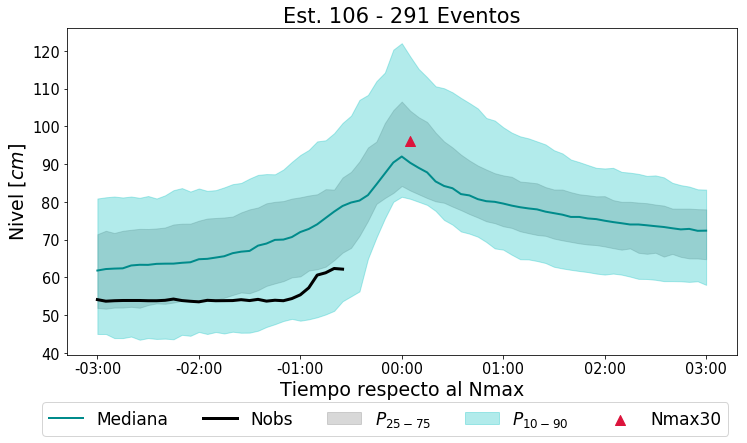

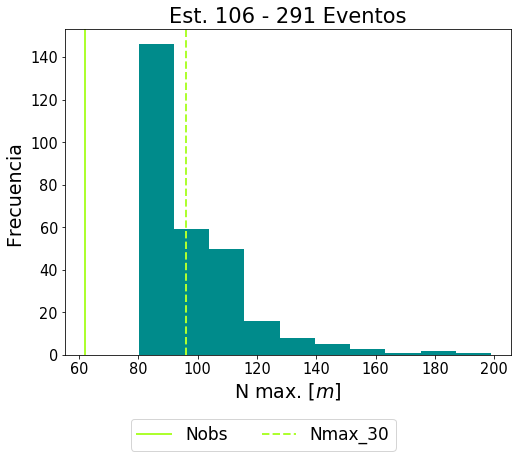

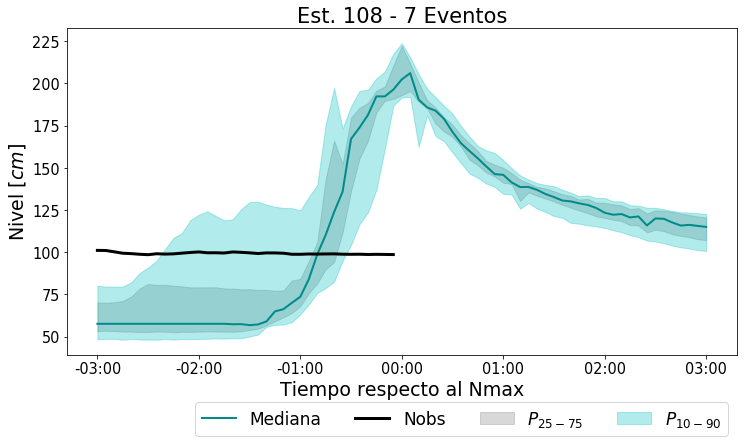

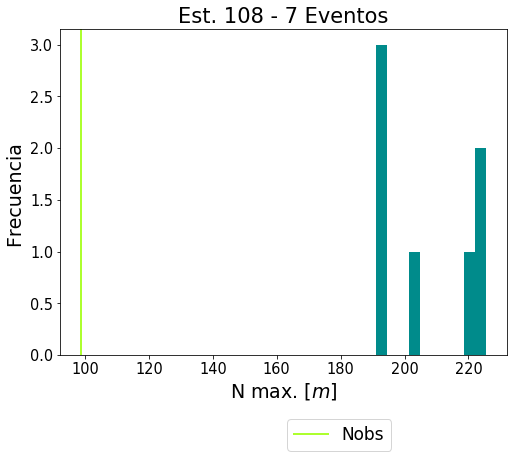

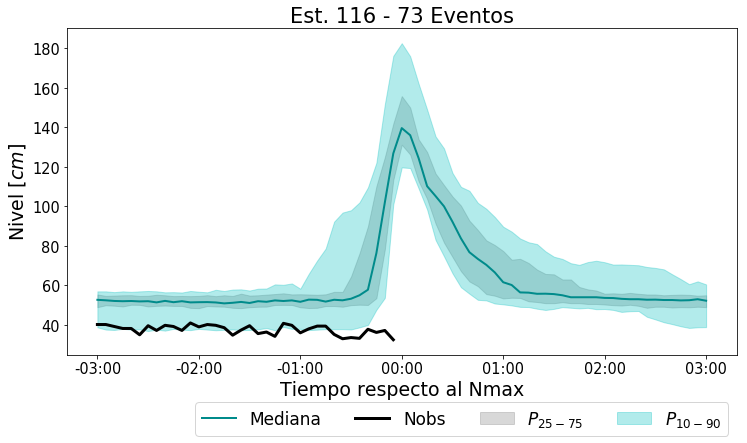

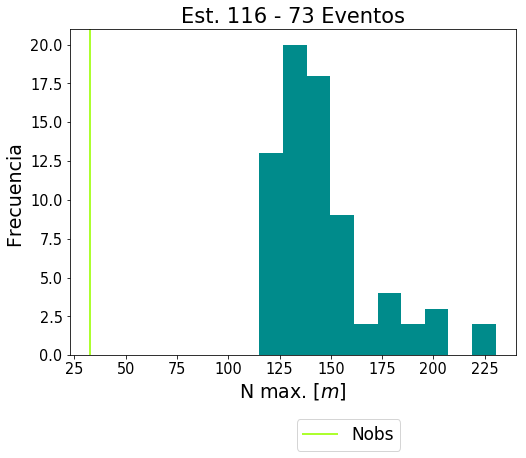

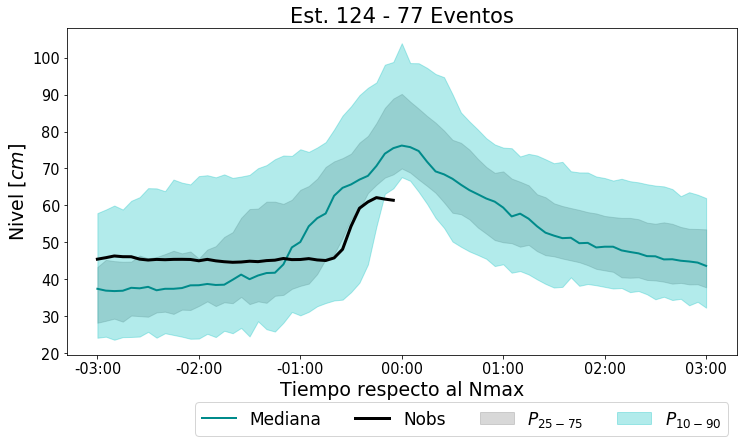

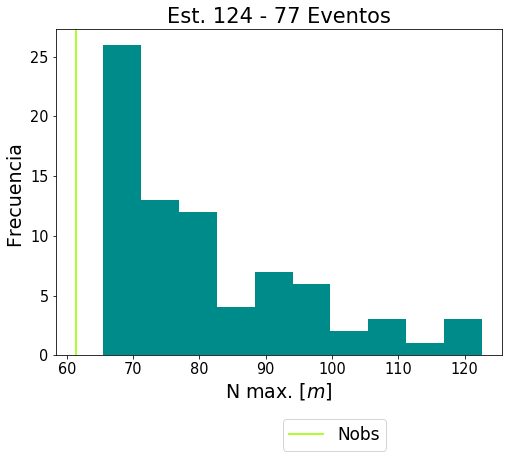

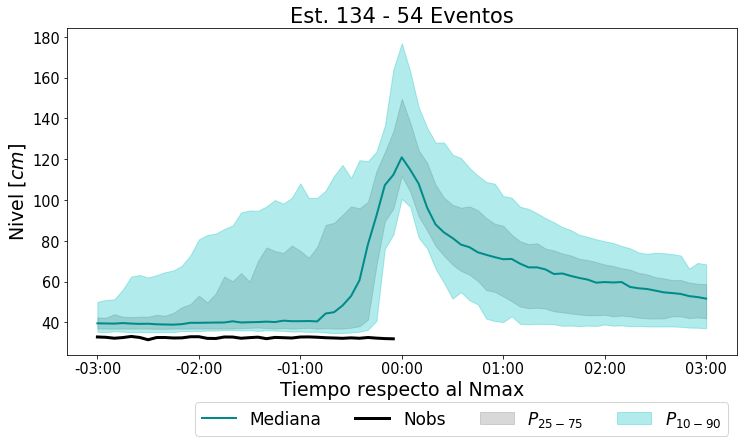

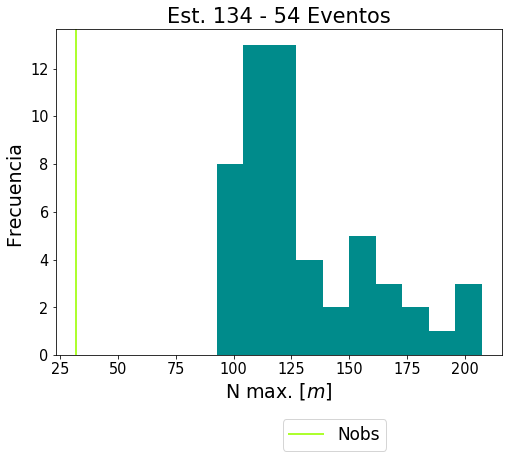

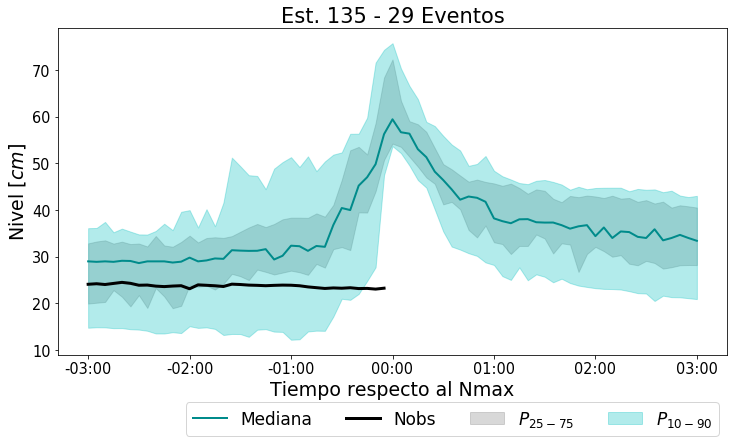

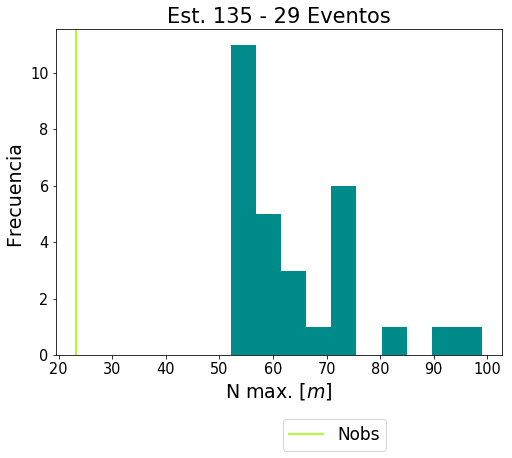

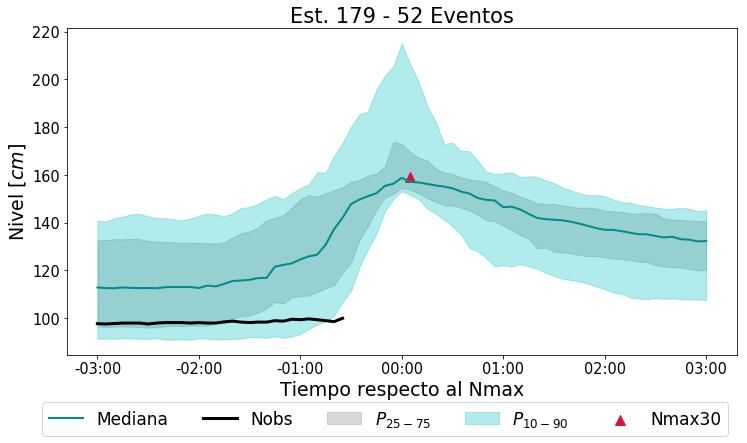

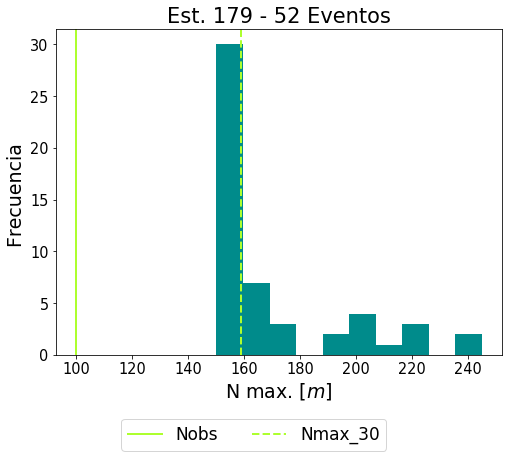

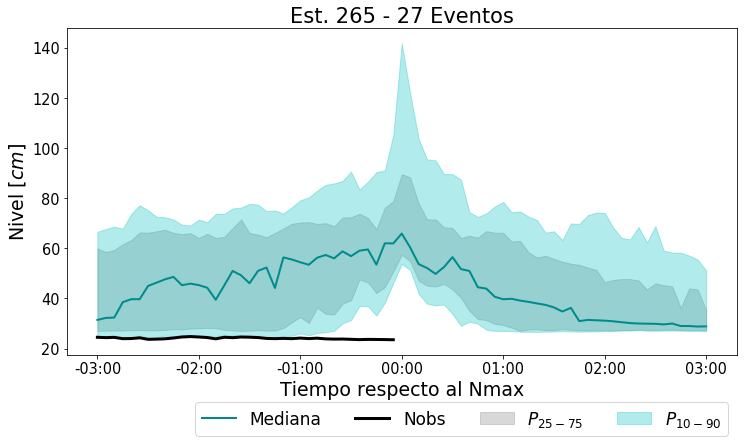

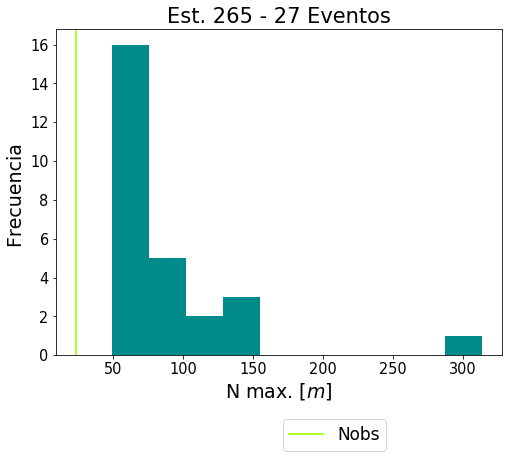

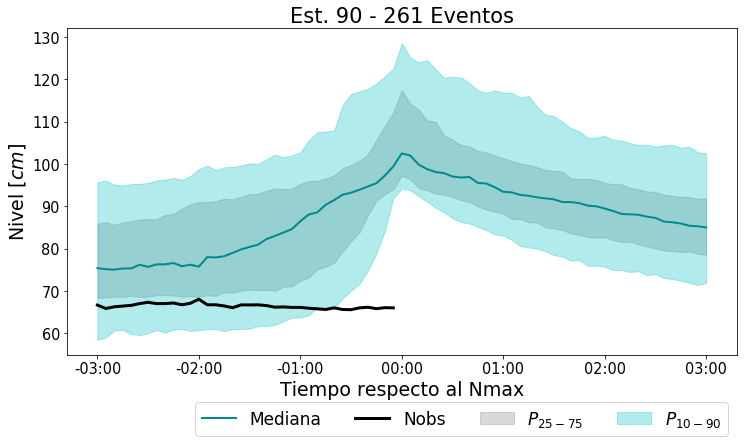

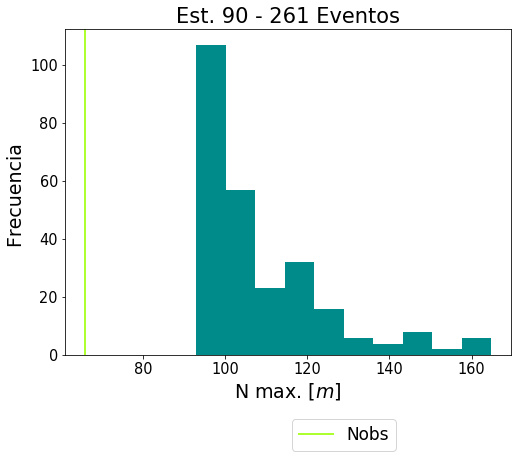

In [7]:
#estaciones.
ests=np.unique(np.hstack(dfconfig['EstNivel']))
ests=ests[np.where(ests)[0]]
est_outfig=[246,272,239,173,186,251,259,283,155]

# #fechas de consulta nivel.
# start=(dt.datetime.now()-pd.Timedelta('3 hours')).strftime('%Y-%m-%d-%H:%M')
# end=dt.datetime.now().strftime('%Y-%m-%d-%H:%M')


for est in np.unique(ests):
    if int(est) in est_outfig:
        pass
    else:
        plotN_vs_History(int(est),ruta_consultaN3h,dfconfig,n_pronos,rutaN,rutafigsN,rng1,timedeltaEv)

Prueba desde el modulo.

No hay datos en los ultimos 5 min.
No hay datos en los ultimos 5 min.


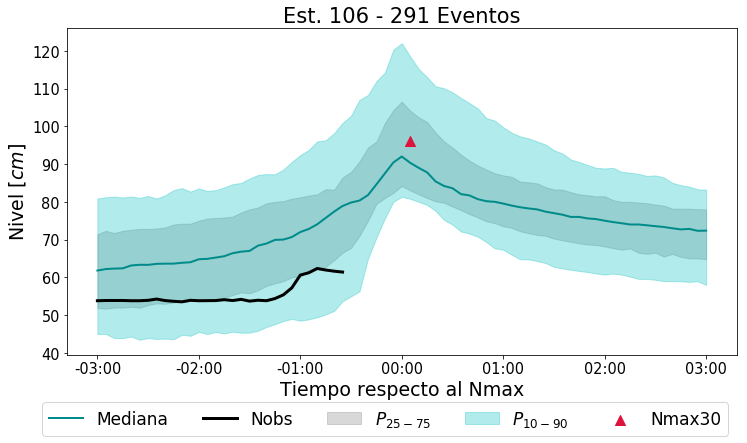

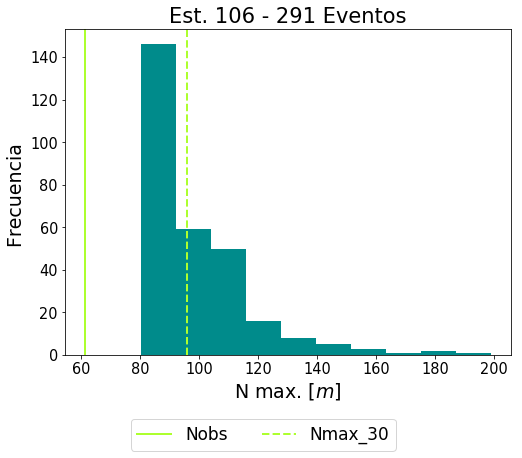

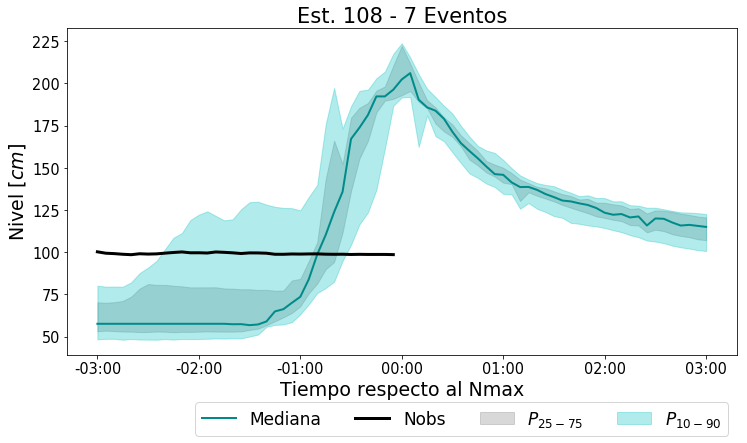

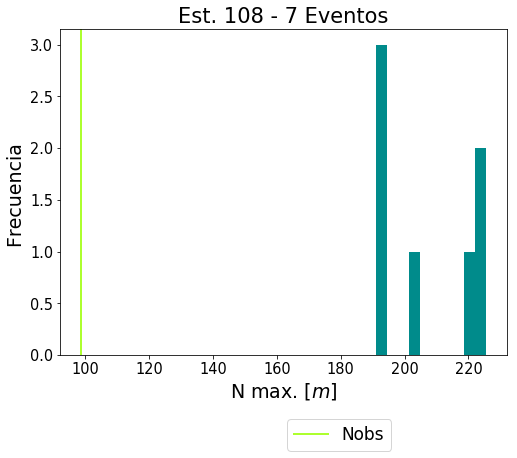

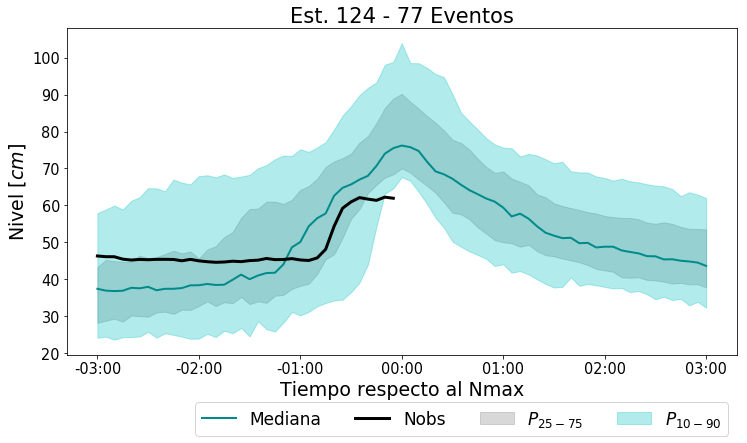

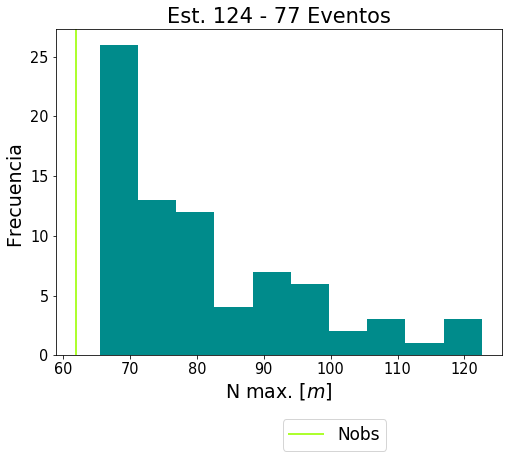

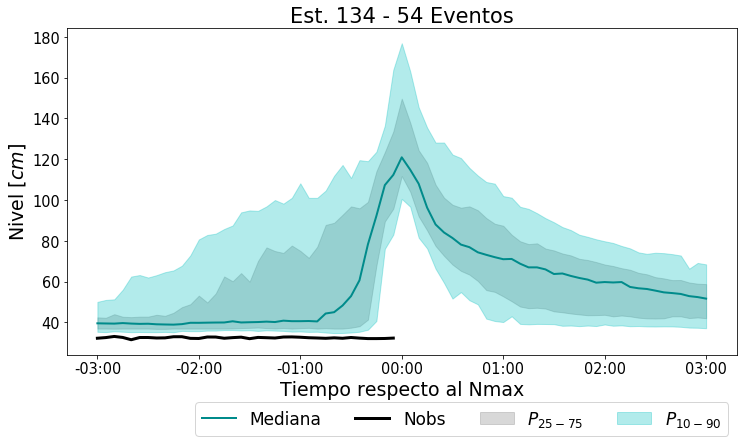

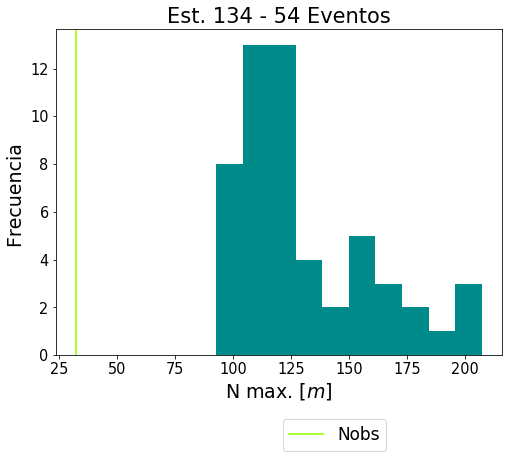

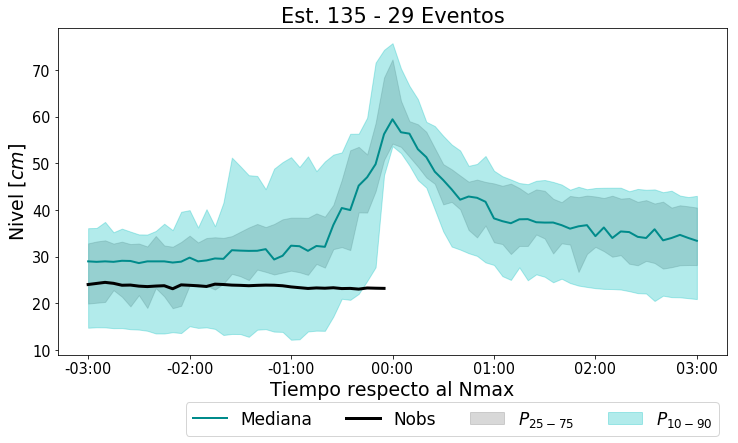

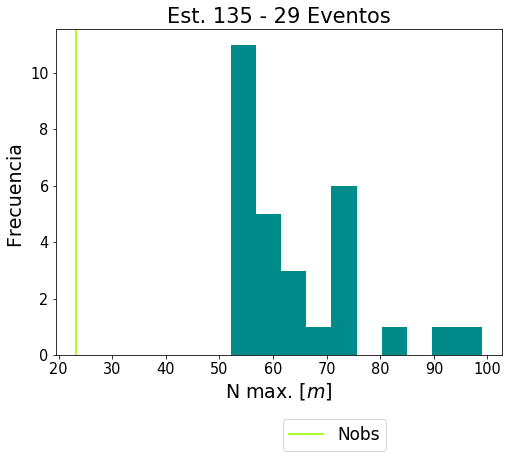

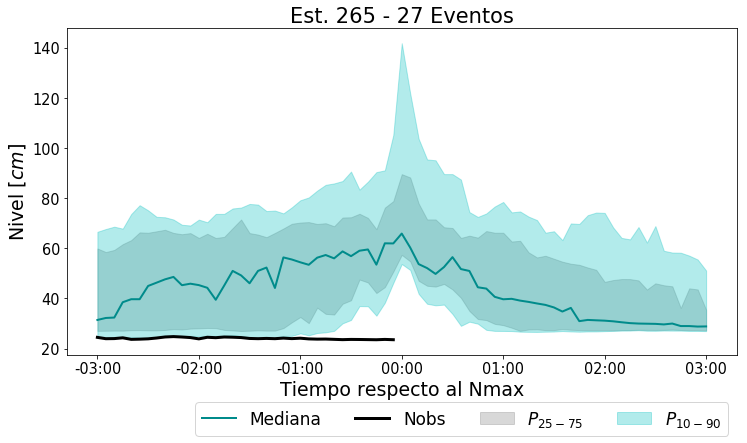

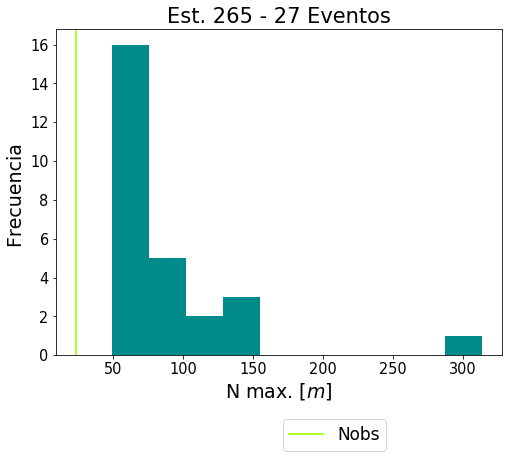

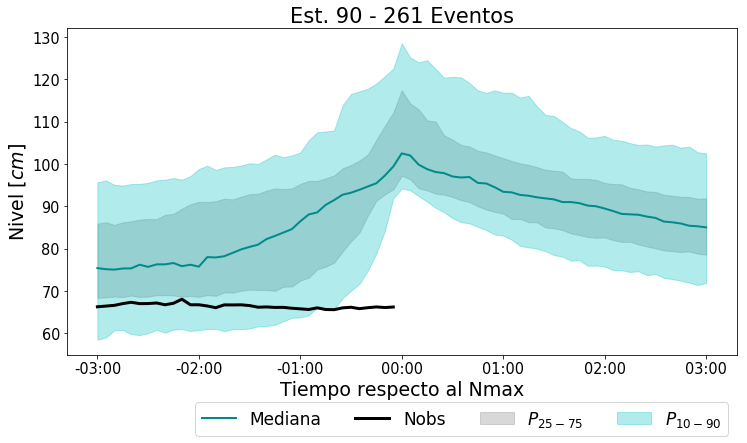

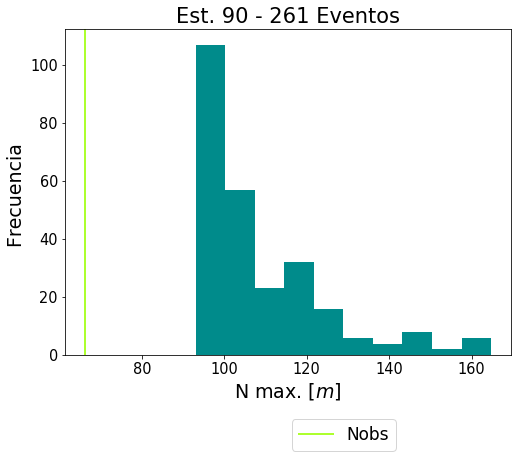

In [5]:
#estaciones.
ests=np.unique(np.hstack(dfconfig['EstNivel']))
ests=ests[np.where(ests)[0]]
est_outfig=[246,272,239,173,186,251,259,283,155]

# #fechas de consulta nivel.
# start=(dt.datetime.now()-pd.Timedelta('3 hours')).strftime('%Y-%m-%d-%H:%M')
# end=dt.datetime.now().strftime('%Y-%m-%d-%H:%M')


for est in np.unique(ests):
    if int(est) in est_outfig:
        pass
    else:
        al.plotN_vs_History(int(est),ruta_consultaN3h,dfconfig,n_pronos,rutaN,rutafigsN,rng1,timedeltaEv)

#### Pluvio

cast_normal
rutaP
rutafigsP

#este se corre solo cuando el pronostico de lluvia sea diferente de cero.
#o cuando el el acumulado final sea diferente de cero.
#un solo pico

Prueba funcion en modulo

In [20]:
def plotP_vs_History(est_p,start,end,rutaP,rutafigsP,cast_normal,rng1,timedeltaEv):
    #Consulta
    self = cpr.Pluvio(int(est_p))
    pluvio = self.read_pluvio(start,end)
    #si la media de los ultimos 5 minutos o el dato -2 es nan.. no hay datos- : no hago nada.
    if (np.isnan(pluvio[-5:].mean()) or np.isnan(pluvio[-2])) or (pluvio[-5:].mean()==0):
        print 'Est '+str(est_p)+': No hay datos en los ultimos 5 min... o son cero.'
        pass
    else:
        pluvio=(pluvio.resample('5T').mean())
        P3h=pluvio[pd.to_datetime(end)-pd.Timedelta('3 hours'):][:-1]
        #Pacum de consulta
        Pacum1d=pluvio[pd.to_datetime(end)-pd.Timedelta('1 days'):][:-1].sum()
        Pacum3d=pluvio[pd.to_datetime(end)-pd.Timedelta('3 days'):][:-1].sum()
        #intervalo de 6
        P6h=pluvio[pd.to_datetime(end)-pd.Timedelta('6 hours'):][:-1]
        pos0=P6h.index.get_loc(P3h.index[0])
        P3h=P6h[pd.to_datetime(end)-pd.Timedelta('3 hours'):]
        P=P3h.append(cast_normal[str(est_p)])

        #Se abren los archivos historicos
        #bandas
        Pbandas=pd.read_csv(rutaP+'bandas_'+str(est_p)+'.csv')
        #Pacum
        Pacum=pd.read_csv(rutaP+'Pacum_'+str(est_p)+'.csv')
        Pacum.index=Pacum[Pacum.keys()[0]]
        Pacum=Pacum.drop(Pacum.keys()[0],axis=1)

        #que plotear
        #cast cero, no esta lloviendo
        if cast_normal[str(est_p)].all() == 0:
#                 print 'aqui'
            Yo=P.cumsum()[:-(60/timedeltaEv)-1]
            Xo=np.arange(0,Yo.size)
            Yc=P.cumsum()[-(60/timedeltaEv)-1:]
            Xc=np.arange(P3h.size,P.size)
        else:
#                 print 'aqui1'
            #pongo cast en la mitad, recortando la serie.
            if P.sum() > P3h.sum():
#                     print 'aqui2'
                Yo=P3h.cumsum()[(60/timedeltaEv)+1:]
                Xo=np.arange(0,Yo.size)
                Yc=P.cumsum()[-(60/timedeltaEv)-1:]
                Xc=np.arange(Yo.size,Yo.size+Yc.size)
            #pongo maximo en la mitad, alargando la serie hacia atras.
            elif P.sum() <= P3h.sum():
#                     print 'aqui3'
                stepback=60/timedeltaEv#P3h.size-P3h.values.argmax()
                Yo=P6h[pos0-stepback:].cumsum()
                Xo=np.arange(0,Yo.size)
                Yc=P.cumsum()[-(60/timedeltaEv):]
                Xc=np.arange(Yo.size,Yo.size+Yc.size)
            else:
                print 'no hay series para graficar'
        #FIGURE
        fig=pl.figure(figsize=(12,6))
        ax=fig.add_subplot(111)
        ax.plot(Pbandas['0.5'],color='darkcyan',label='Mediana',lw=3)
        ax.fill_between(np.arange(Pbandas['0.1'].size),Pbandas['0.25'],Pbandas['0.75'],color='gray',alpha=0.3,label='$P_{25-75}$')
        ax.fill_between(np.arange(Pbandas['0.1'].size),Pbandas['0.1'],Pbandas['0.9'],color='c',alpha=0.3,label='$P_{10-90}$')
#                 ax.plot(Pbandas['0.25'],color='darkcyan',label='$P_{25}$',lw=2,ls='--')
#                 ax.plot(Pbandas['0.75'],color='darkcyan',label='$P_{75}$',lw=2,ls='--')
        ax.plot(Xo,Yo.values,c='k',lw=2.5,label='Pacum_3h')
        ax.plot(Xc,Yc.values,c='k',lw=2.5,ls='--',label='Pacum_cast')
        ax.set_ylabel(u'Evolucion $P_{acum}$ historica $[mm]$', size= 19)
        ax.set_xlabel(u'Tiempo respecto al Nmax', size= 18)
        ax.set_title('Est. '+ str(est_p)+' - '+str(np.array(Pacum[Pacum.index=='Pacum3h'])[0].size)+' Eventos',fontsize=21)
        ax.tick_params(labelsize=14.5)
        ax.set_xticks(np.arange(0,Pbandas.shape[0],60/timedeltaEv))
        ax.set_xticklabels(rng1)
        legend = ax.legend(fontsize=15,bbox_to_anchor =(1,-0.150),ncol=6)
        pl.savefig(rutafigsP+'Pshape_'+str(est_p)+'.png',bbox_inches='tight',bbox_extra_artists=[legend])
        #Pacum3h
        fig=pl.figure(figsize=(7,5))
        ax=fig.add_subplot(111)
        pl.hist(np.array(Pacum[Pacum.index=='Pacum3h'])[0],color='darkcyan')
        pl.axvline(P3h.sum(),c='greenyellow',lw=2,label=u'$P_{acumUlt3h}$')
        pl.axvline(P.sum(),c='greenyellow',lw=2,label=u'$P_{acumcast}$',ls='--')
        ax.set_ylabel('Frecuencia ', size= 17)
        ax.set_xlabel(u'$P_{acum3h}$ Eventos $[mm]$', size= 16)
        ax.set_title('Est. '+ str(est_p)+' - '+str(np.array(Pacum[Pacum.index=='Pacum3h'])[0].size)+' Eventos',fontsize=17)
        ax.tick_params(labelsize=13.5)
        ax.legend(fontsize=14)
        pl.savefig(rutafigsP+'Phist3h_'+str(est_p)+'.png')
        #Pacum1d
        fig=pl.figure(figsize=(7,5))
        ax=fig.add_subplot(111)
        pl.hist(np.array(Pacum[Pacum.index=='Pacum1'])[0],color='darkcyan')
        pl.axvline(Pacum1d,c='greenyellow',lw=2,label=u'$P_{acumUlt1d}$')
        ax.set_ylabel('Frecuencia ', size= 17)
        ax.set_xlabel(u'$P_{acum1d}$ Eventos $[mm]$', size= 16)
        ax.set_title('Est. '+ str(est_p)+' - '+str(np.array(Pacum[Pacum.index=='Pacum3h'])[0].size)+' Eventos',fontsize=17)
        ax.tick_params(labelsize=13.5)
        ax.legend(fontsize=14)
        pl.savefig(rutafigsP+'pruebas/Phist1d_'+str(est_p)+'.png')
        #Pacum3d
        fig=pl.figure(figsize=(7,5))
        ax=fig.add_subplot(111)
        pl.hist(np.array(Pacum[Pacum.index=='Pacum3'])[0],color='darkcyan')
        pl.axvline(Pacum3d,c='greenyellow',lw=2,label=u'$P_{acumUlt3d}$')
        #pl.axvline(P.sum(),c='greenyellow',lw=2,label=u'$P_{acumcast}$',ls='--')
        ax.set_ylabel('Frecuencia ', size= 17)
        ax.set_xlabel(u'$P_{acum3d}$ Eventos $[mm]$', size= 16)
        ax.set_title('Est. '+ str(est_p)+' - '+str(np.array(Pacum[Pacum.index=='Pacum3h'])[0].size)+' Eventos',fontsize=17)
        ax.tick_params(labelsize=13.5)
        ax.legend(fontsize=14)
        pl.savefig(rutafigsP+'pruebas/Phist3d_'+str(est_p)+'.png')

In [6]:
est_noH=[267,281,43 ,261,253]
#se leen las est a plotear
paths_p=glob.glob(rutaP+'bandas*')
ests_p=[i.split('/')[-1].split('_')[-1][:-4] for i in paths_p]

In [10]:
est_p=ests_p[0]

In [11]:
self = cpr.Pluvio(int(est_p))
pluvio = self.read_pluvio(start,end)

True

In [19]:
if (np.isnan(pluvio[-5:].mean()) or np.isnan(pluvio[-2])) or (pluvio[-5:].mean()==0):
    print 'Est '+str(est_p)+': No hay datos en los ultimos 5 min... o son cero.'
else:
    print 'hay dato'

Est 8: No hay datos en los ultimos 5 min... o son cero.


In [5]:
#fechas para consultar pluvio.
start=(dt.datetime.now()-pd.Timedelta('3 days')).strftime('%Y-%m-%d-%H:%M')
end=dt.datetime.now().strftime('%Y-%m-%d-%H:%M')
# for para todas
for est_p in np.sort(ests_p):
    if int(est_p) in est_noH:
        pass
    else:
        plotP_vs_History(est_p,start,end,rutaP,rutafigsP,cast_normal,rng1,timedeltaEv)

NameError: name 'ests_p' is not defined

Prueba desde el modulo

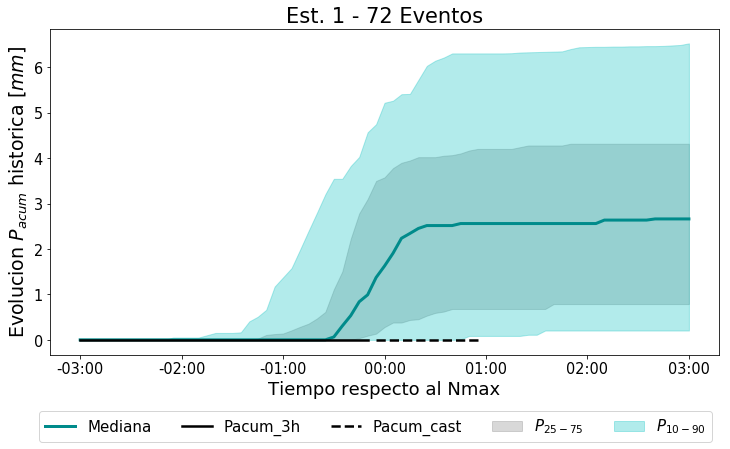

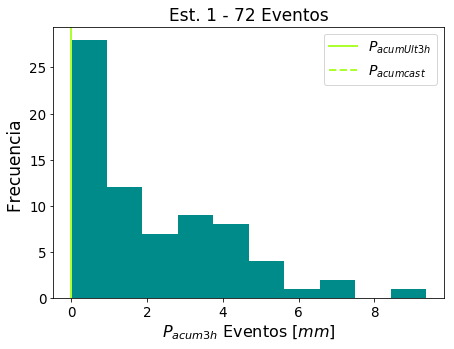

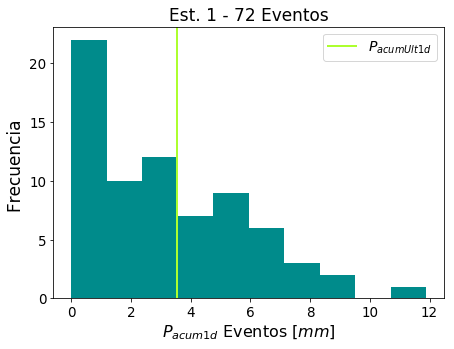

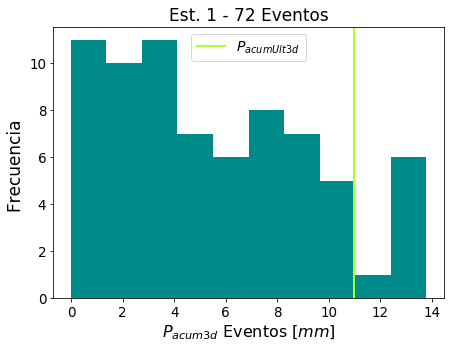

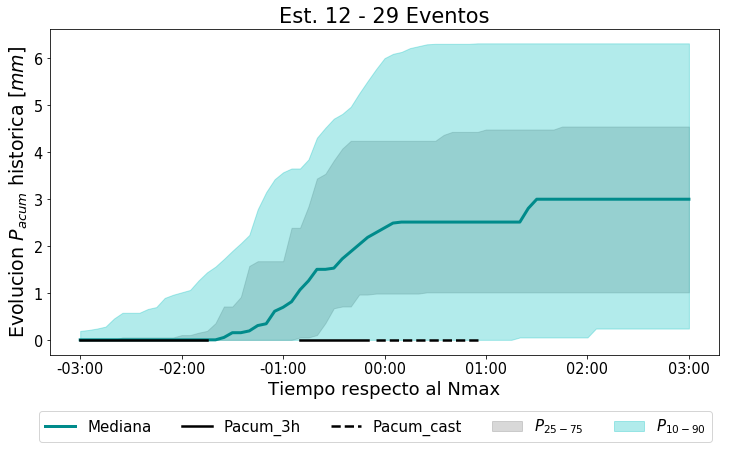

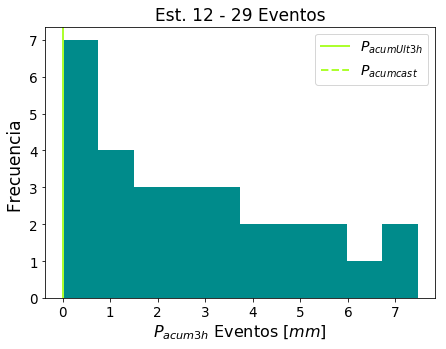

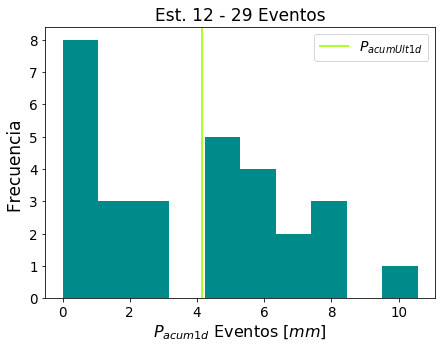

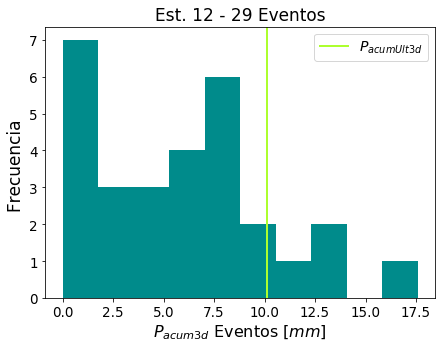

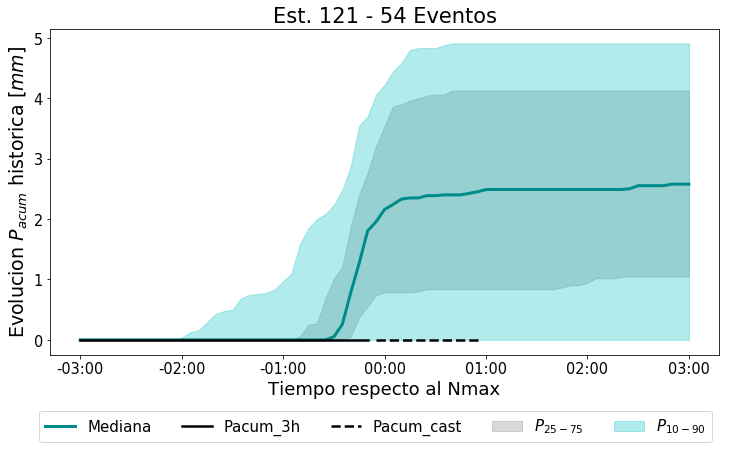

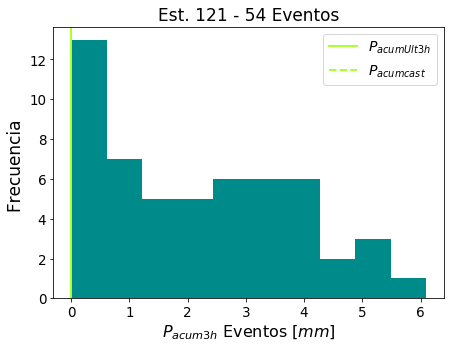

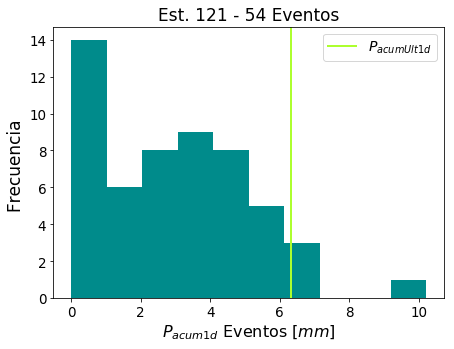

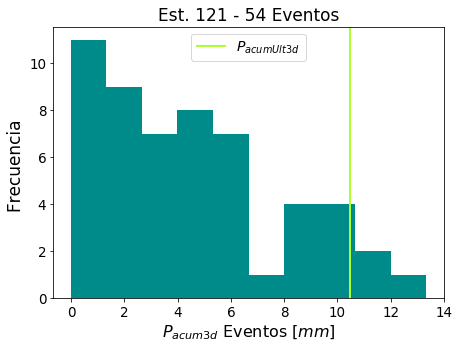

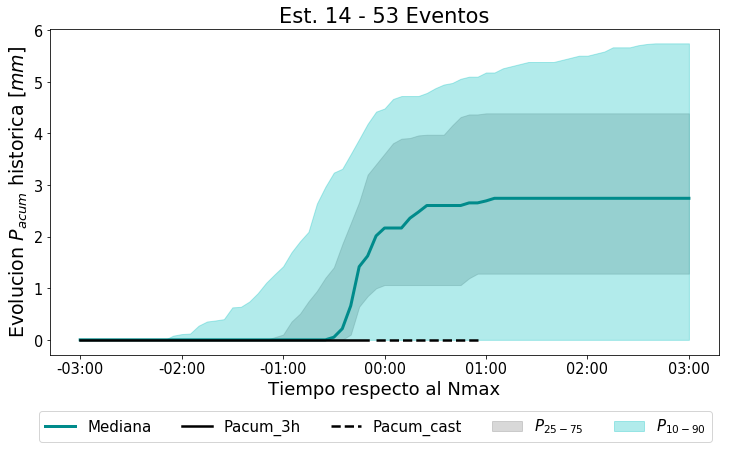

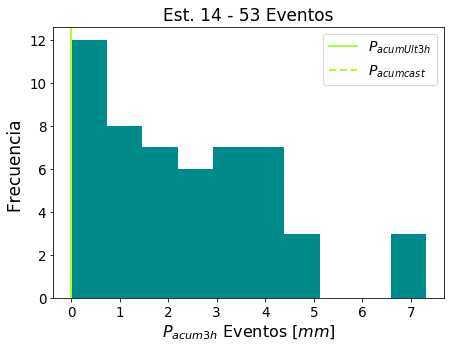

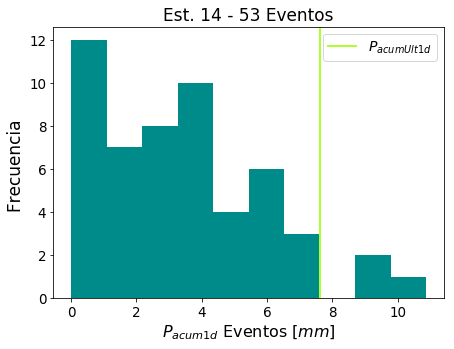

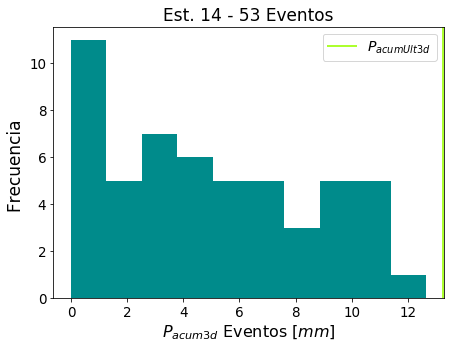

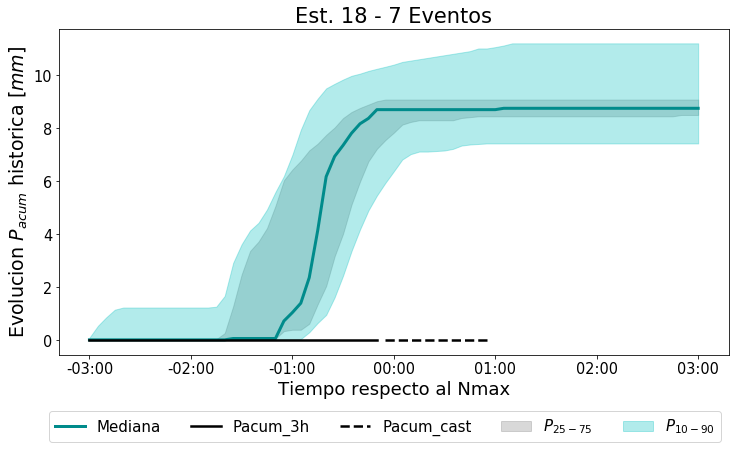

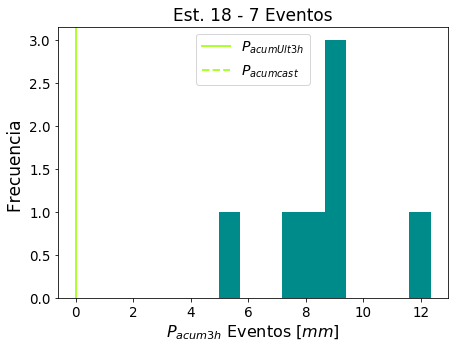

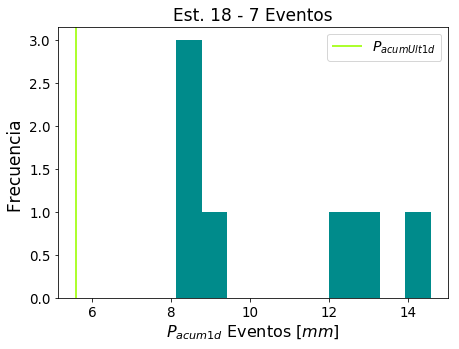

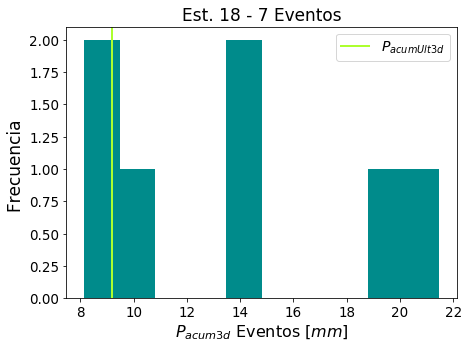

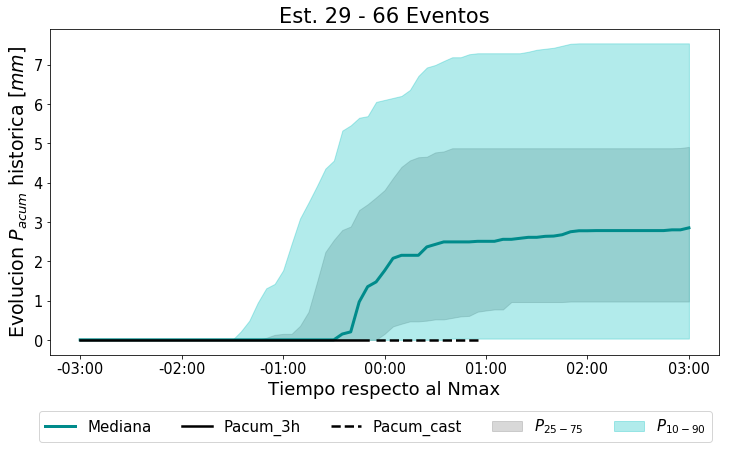

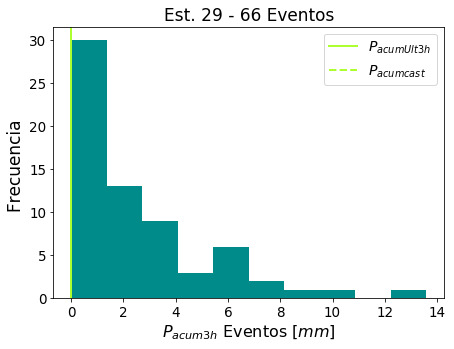

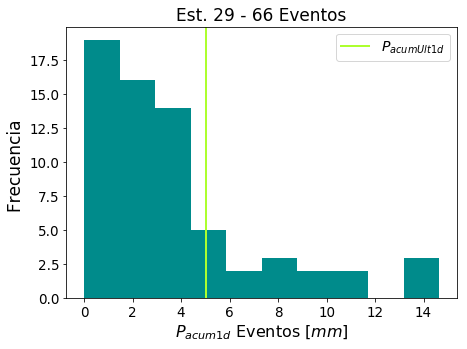

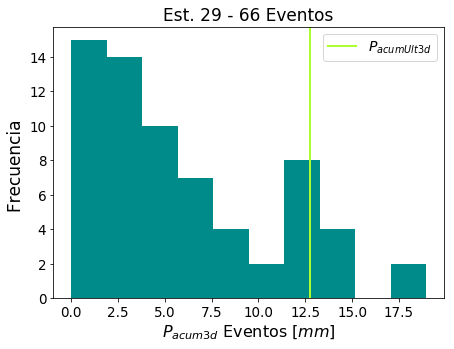

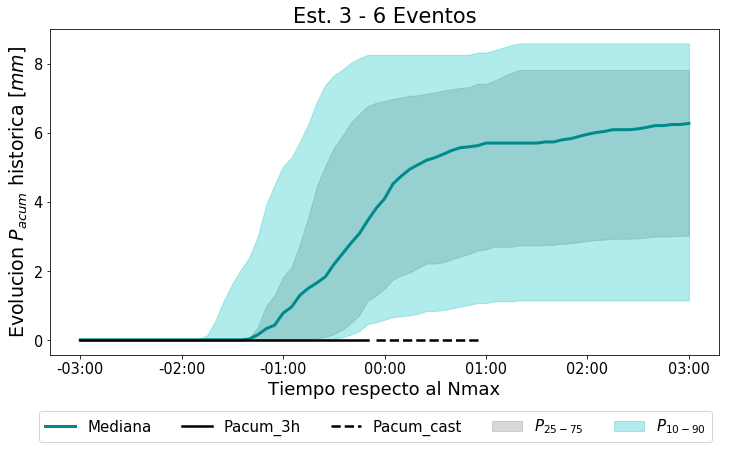

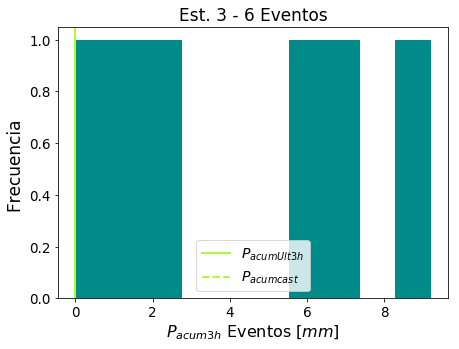

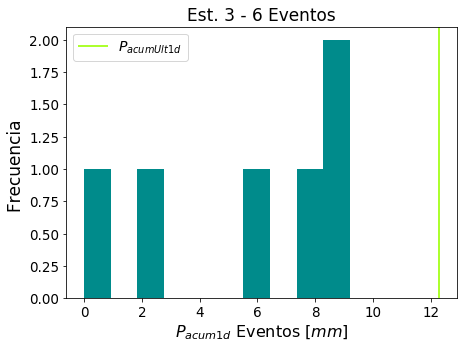

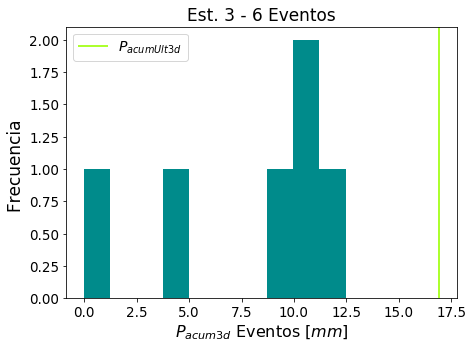

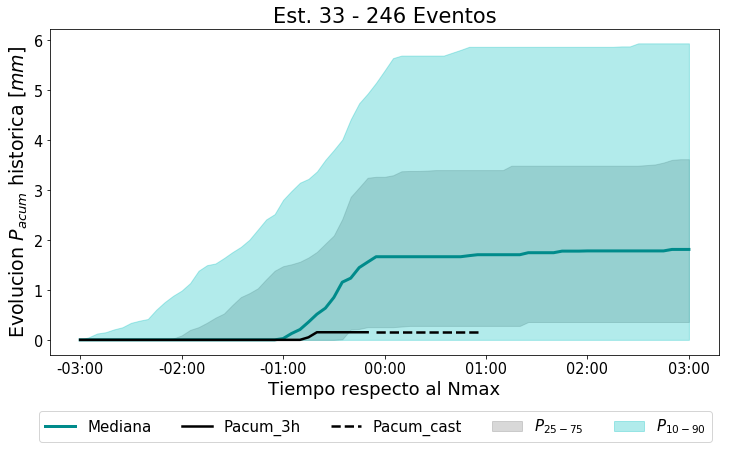

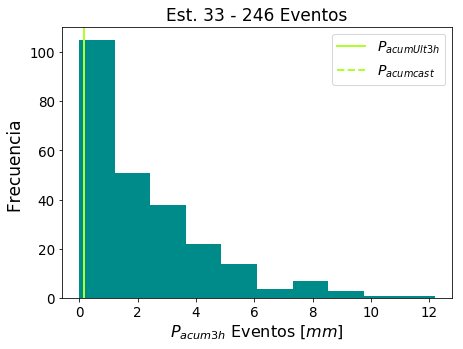

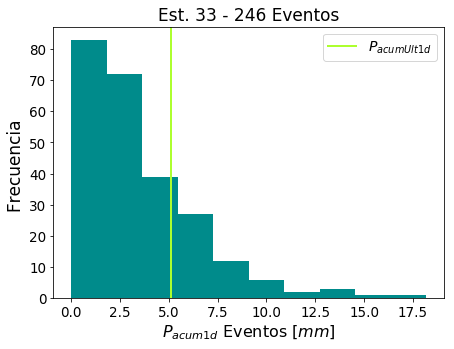

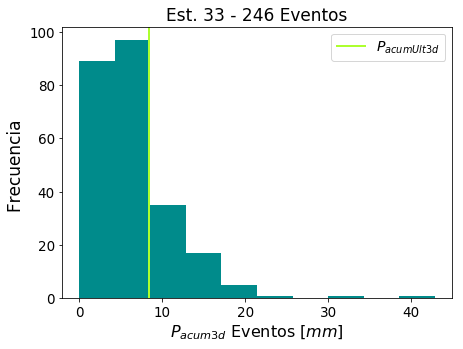

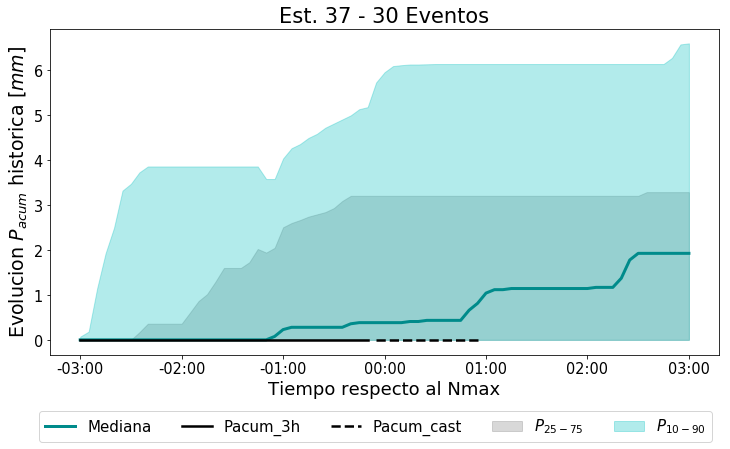

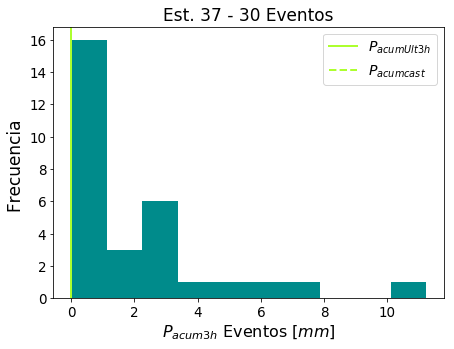

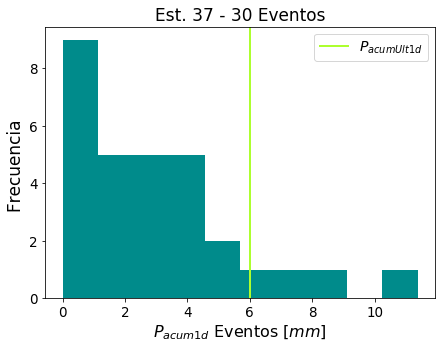

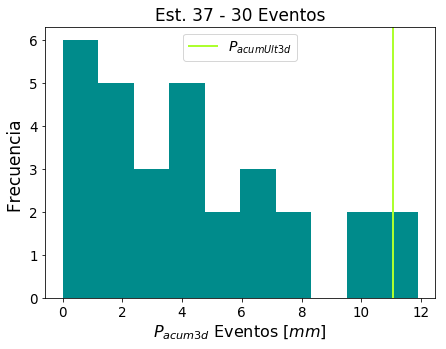

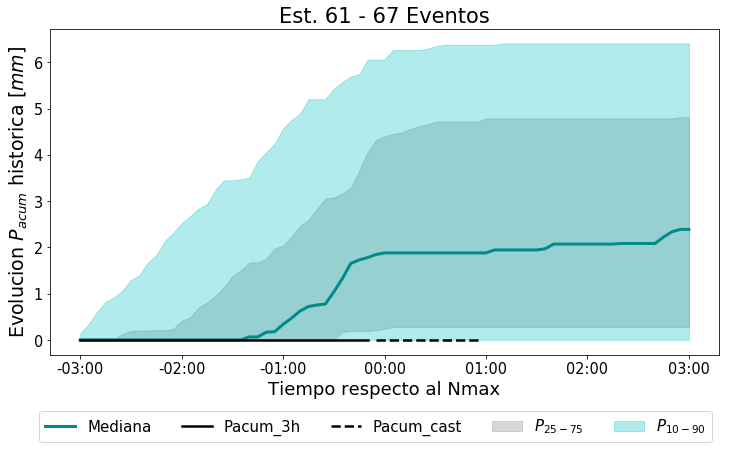

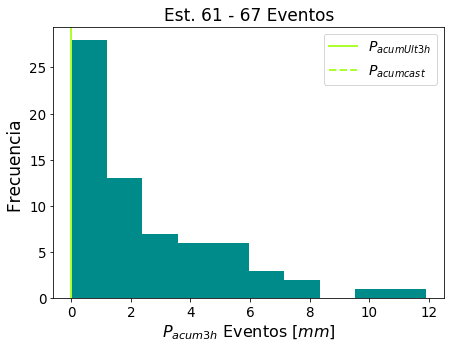

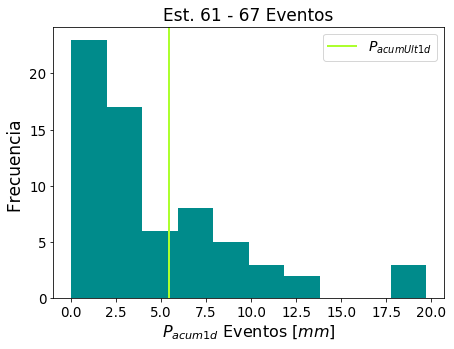

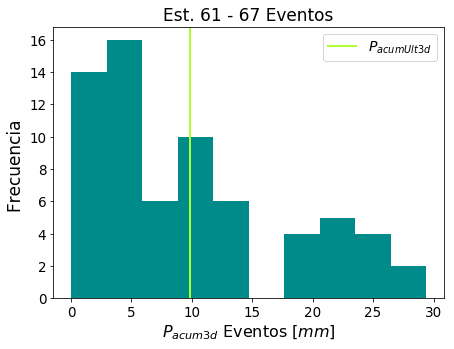

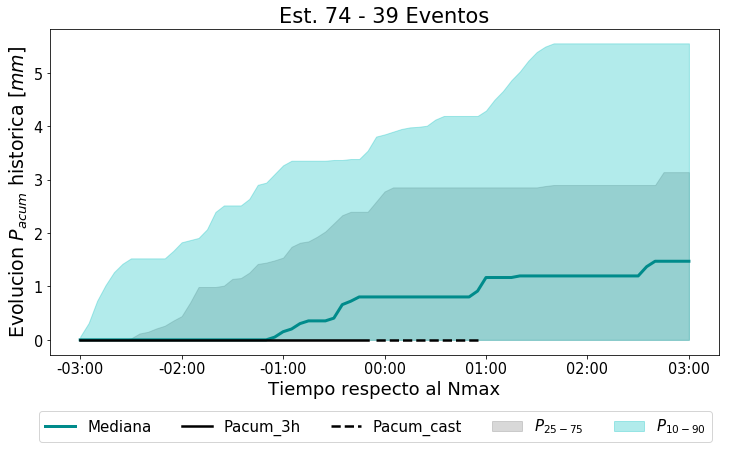

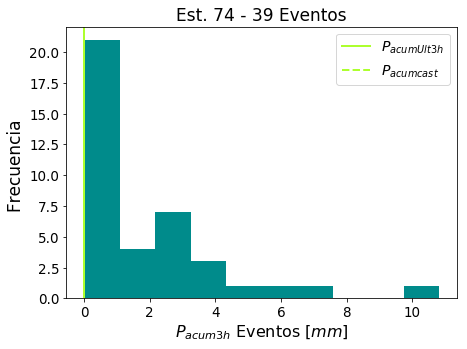

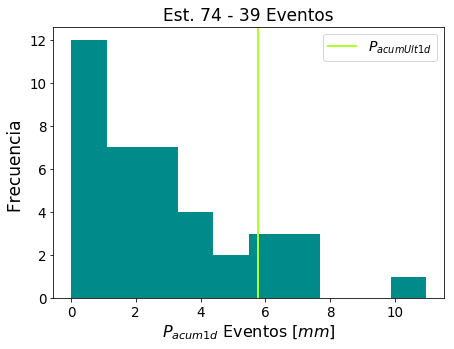

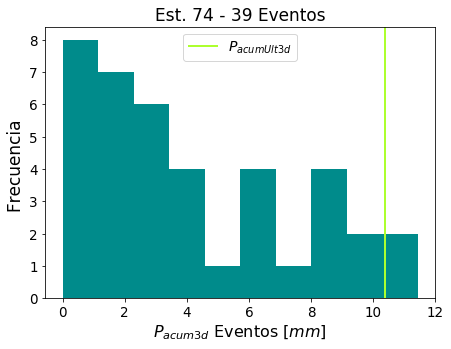

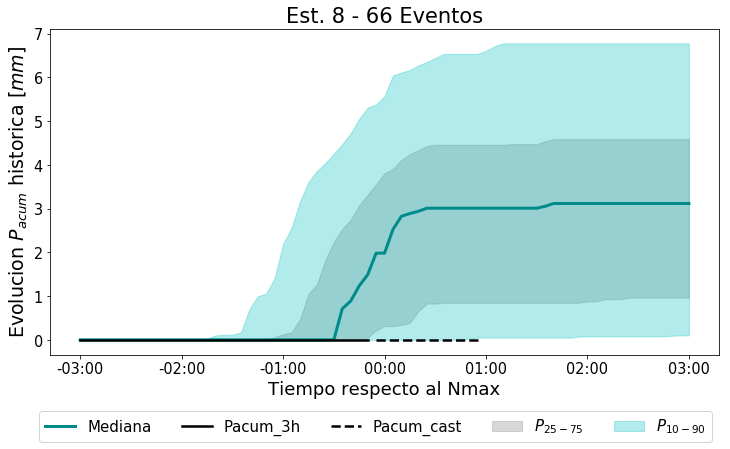

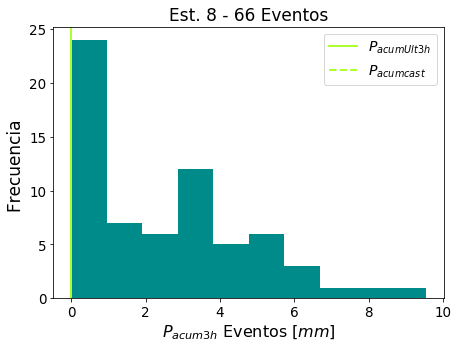

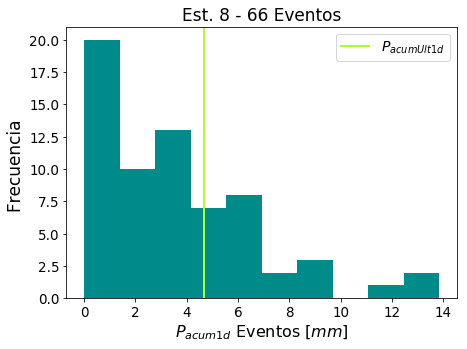

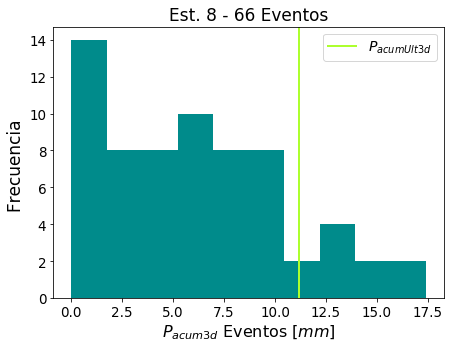

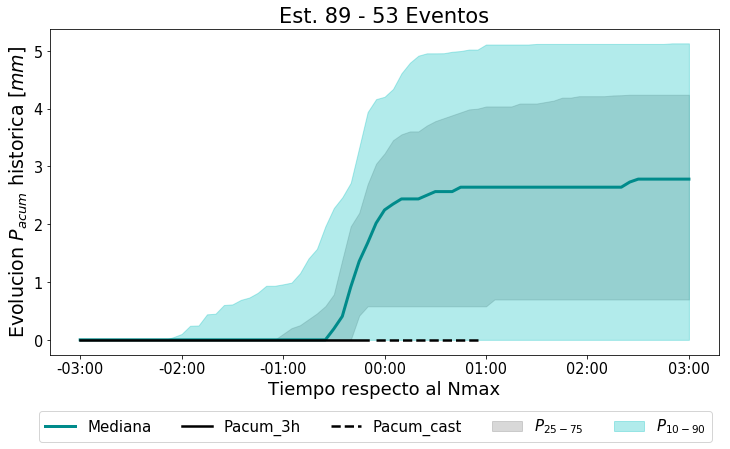

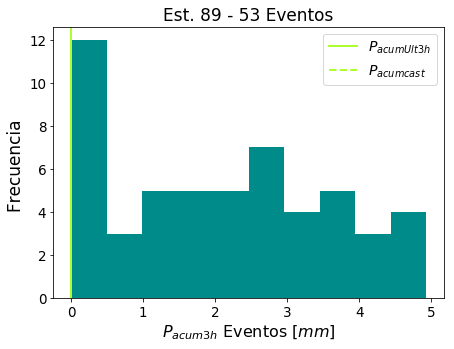

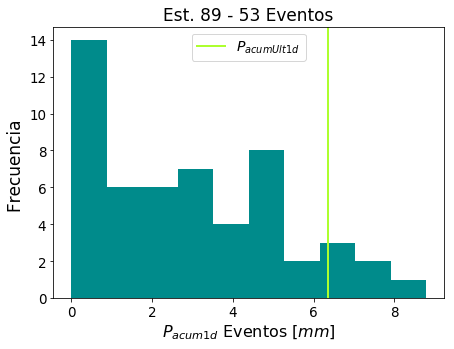

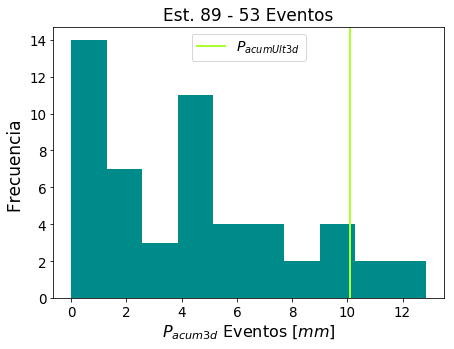

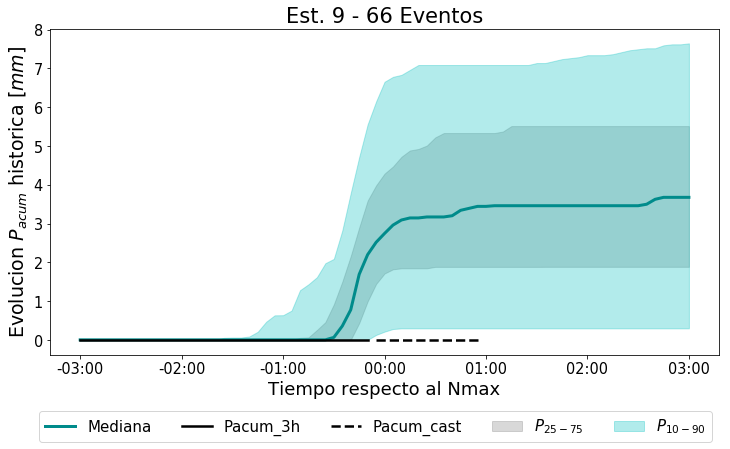

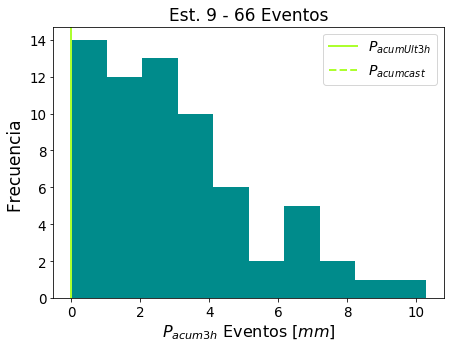

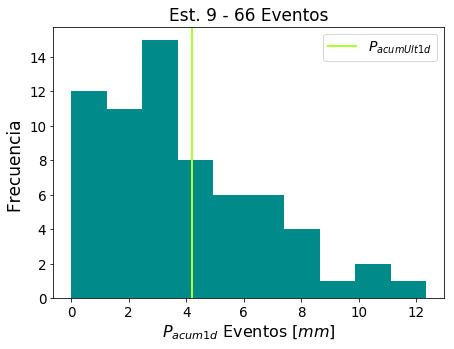

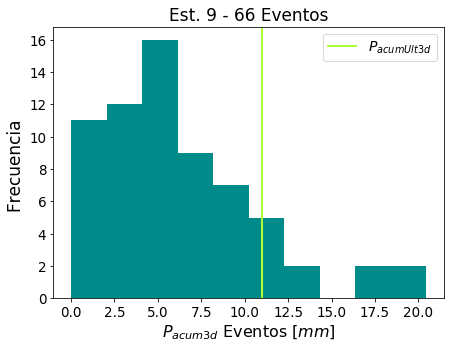

In [26]:
est_noH=[267,281,43 ,261,253]
#se leen las est a plotear
paths_p=glob.glob(rutaP+'bandas*')
ests_p=[i.split('/')[-1].split('_')[-1][:-4] for i in paths_p]
#fechas para consultar pluvio.
start=(dt.datetime.now()-pd.Timedelta('3 days')).strftime('%Y-%m-%d-%H:%M')
end=dt.datetime.now().strftime('%Y-%m-%d-%H:%M')
# for para todas
for est_p in np.sort(ests_p):
    if int(est_p) in est_noH:
        pass
    else:
        al.plotP_vs_History(est_p,start,end,rutaP,rutafigsP,cast_normal,rng1,timedeltaEv)

# ---